In [45]:
import os
import time
import cv2 as cv

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.utils as utils
from torchvision.utils import save_image

import warnings
warnings.filterwarnings("ignore")

In [46]:
# Model runs on GPU if it's available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Save the dataset at this directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
INTERMEDIATE_IMAGES = os.path.join(DATA_DIR_PATH, 'intermediate_images')

# Understanding the data
I'll be using the MNIST dataset to train the GAN model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The shape of the images are: torch.Size([1, 28, 28])


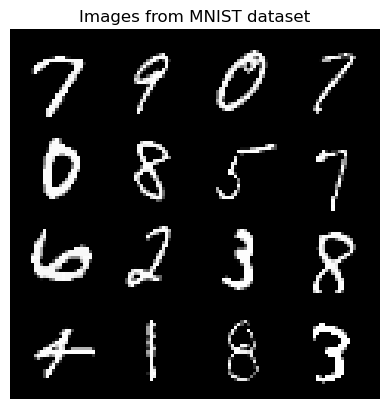

In [47]:
batch_size = 128

# In the MNIST dataset in PyTorch, the pixel values are automatically normalized to the range [0, 1]
# The images are first converted to PyTorch Tensors
# The data is then re-normalized to be in the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# The MNIST dataset is a collection of 70,000 handwritten digits (0-9) with 28x28 pixel resolution images
# The above transform will be applied to every image in the dataset
mnist_dataset = datasets.MNIST(root=DATA_DIR_PATH, train=True, download=True, transform=transform)

# Divides the data into batches of size 'batch_size'
mnist_data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Consider the first batch of images
images, labels = next(iter(mnist_data_loader)) 

# What's the shape of the images?
print(f'The shape of the images are: {images.shape[1:]}')

# Visualize the images
no_of_images = 16
image_subset = images[:no_of_images] # We take only a subset of images to display

grid = utils.make_grid(image_subset, nrow=int(np.sqrt(no_of_images)))

plt.title('Images from MNIST dataset')
plt.imshow(grid.permute(1, 2, 0)) # Matplotlib takes in images with dimensions of form HWC
plt.axis('off')
plt.show()

## Understanding the Components of GANs
GANs have two components:
1. <b>Generator Network:</b> The generator network takes a random noise vector as input and generates a new image.
2. <b>Discriminator Network:</b> The discriminator network takes an image as input and outputs a scalar value indicating whether the image is real or fake.

---

### How do the two networks work together?
> According to Goodfellow et al. (2014), "The training procedure for Generator model is to maximize the probability of Discriminator making a mistake. This framework corresponds to a <b>minimax two-player game.<b>"

## Generator Network
+ `LeakyReLU` is used as a non-linear activation here.<br>
+ `Batch Normalization` is used after each linear layer
+ The last layer of the generator network is a `Tanh` function.

Learnt some useful insights from https://github.com/soumith/ganhacks

In [48]:
class Generator(nn.Module):
    def __init__(self, noise_dim, image_dim):
        super().__init__()
        num_neurons_per_layer = [256, 512, 1024]
        self.noise_dim = noise_dim
        self.image_dim = image_dim
        
        self.net = nn.Sequential(
            nn.Linear(self.noise_dim, num_neurons_per_layer[0]),
            nn.BatchNorm1d(num_neurons_per_layer[0]),
            nn.LeakyReLU(0.2),
           
            nn.Linear(num_neurons_per_layer[0], num_neurons_per_layer[1]),
            nn.BatchNorm1d(num_neurons_per_layer[1]),
            nn.LeakyReLU(0.2),
            
            nn.Linear(num_neurons_per_layer[1], num_neurons_per_layer[2]),
            nn.BatchNorm1d(num_neurons_per_layer[2]),
            nn.LeakyReLU(0.2),
            
            nn.Linear(num_neurons_per_layer[2], self.image_dim),
            nn.Tanh() # Normalizes the data into [-1, 1] range                       
        )
        
    def forward(self, noise):
        image_batch_flattened = self.net(noise) # flattened image of dimension (N, HXW) N -> batch size
        # un-flattening image into dimensions (N, 1, 28, 28) for MNIST
        return image_batch_flattened.view(image_batch_flattened.shape[0], 1, 28, 28) 
        

## Discriminator Network

In [49]:
class Discriminator(nn.Module):
    def __init__(self, image_dim):
        super().__init__()
        num_neurons_per_layer = [512, 256, 1]
        
        self.net = nn.Sequential(
            nn.Linear(image_dim, num_neurons_per_layer[0]),
            nn.LeakyReLU(0.2),
           
            nn.Linear(num_neurons_per_layer[0], num_neurons_per_layer[1]),
            nn.LeakyReLU(0.2),
            
            nn.Linear(num_neurons_per_layer[1], num_neurons_per_layer[2]),
            nn.Sigmoid() 
        )
        
    def forward(self, image):
        image_batch_flattened = image.view(image.shape[0], -1) # flatten the image to (N, HxW) N -> batch size
        return self.net(image_batch_flattened)


## Understanding the Training Process

I have made the following changes to the original paper:
1. The original paper used <b>Momentum</b> but I've used <b>Adam optimizer</b> 
2. <b>Hyperparameter</b> values are not the same as experiments in the original paper<br>

---

### Notations used
D - Discriminator Network<br>
G - Generator network<br>
z - random noise<br>
x - Image from the data<br>

---

### Loss Function Intuition
<b>Discriminator</b> wants to maximize `log(D(x)) + log(1 - D(G(z)))`<br>
<b>Generator</b> wants to minimize the above equation but `X = log(1 - D(G(z)))` part can be considered for minimizing<br>
With loss expression X, we see vanishing gradients when D performs very well which is why we maximize the equation `log(D(G(z))`

In [50]:
# Hyperparameters
lr = 3e-4 # A good learning rate for Adam optimizer
num_epochs = 10
noise_dim = 28 * 28 * 1
image_dim = 28 * 28 * 1 # The dimensions of images in MNIST dataset
img_cnt = 0
int_img_grid_size = 16

checkpoint_freq = 2
console_log_freq = 50
intermediate_image_log_freq = 50

generator_loss_values = []
discriminator_loss_values = []

# GAN uses Binary Cross Entropy for it's loss function
adversarial_loss = nn.BCELoss()

discriminator_net = Discriminator(noise_dim).train().to(device)
generator_net = Generator(noise_dim, image_dim).train().to(device)

# We use Adam optimizer for both the neural networks 
discriminator_opt = Adam(discriminator_net.parameters(), lr=lr, betas=(0.5, 0.999))
generator_opt = Adam(generator_net.parameters(), lr=lr, betas=(0.5, 0.999))

# Used later to customize the BCELoss function expression according to needs
ones_tensor = torch.ones((batch_size, 1), device=device)
zeros_tensor = torch.zeros((batch_size, 1), device=device)

In [51]:
ts = time.time()
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(mnist_data_loader):
        
        #-----------------------------------         
        # Training the discriminator network
        #-----------------------------------
        
        real_images = real_images.to(device)
        
        # PyTorch accumulates gradients over the epochs
        # Set the gradients at each step to zero
        discriminator_opt.zero_grad()
        
        # To configure the BCELoss to -log(D(x)), we pass in a tensor of ones 
        real_discriminator_loss = adversarial_loss(discriminator_net(real_images), ones_tensor) 
        
        
        # create random input noise for the generator
        noise = torch.randn(batch_size, noise_dim).to(device)         
        fake_images = generator_net(noise)                                        

        # To configure the BCELoss to -log(1 - D(G(z))), we pass in a tensor of zeros
        fake_images_predictions = discriminator_net(fake_images)
        fake_discriminator_loss = adversarial_loss(fake_images_predictions, zeros_tensor)
        
        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        discriminator_loss.backward()
        discriminator_opt.step()
        
        #-----------------------------------         
        # Training the Generator network
        #-----------------------------------
        
        generator_opt.zero_grad()
        generator_training_noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images_generated = generator_net(generator_training_noise)
        
        generated_image_predictions = discriminator_net(fake_images_generated)
        
        # To configure the BCELoss to -log(D(G(z))), we pass in a tensor of ones
        generator_loss = adversarial_loss(generated_image_predictions, ones_tensor)
        generator_loss.backward()
        generator_opt.step()
        
        generator_loss_values.append(generator_loss.item())
        discriminator_loss_values.append(discriminator_loss.item())
        
        # Save intermediate generator images 
        if batch_idx % intermediate_image_log_freq == 0:
            with torch.no_grad():
                log_generated_images = generator_net(noise)
                log_generated_images_resized = nn.Upsample(scale_factor=2.5, mode='nearest')(log_generated_images)
                out_path = os.path.join(INTERMEDIATE_IMAGES, f'{str(img_cnt).zfill(6)}.jpg')
                save_image(log_generated_images_resized, out_path, nrow=int(np.sqrt(int_img_grid_size)), normalize=True)
                img_cnt += 1
        
        if batch_idx % console_log_freq == 0:
            prefix = 'GAN training: time elapsed'
            print(f'{prefix} = {(time.time() - ts):.2f} [s] | epoch={epoch + 1} | batch= [{batch_idx + 1}/{len(mnist_data_loader)}]')
            print(f"Loss D: {discriminator_loss:.4f}, Loss G: {generator_loss:.4f}")
        
        # Save generator checkpoint
        if (epoch + 1) % checkpoint_freq == 0 and (batch_idx + 1) == 0:
            ckpt_model_name = f"vanilla_ckpt_epoch_{epoch + 1}_batch_{batch_idx + 1}.pth"
            torch.save(generator_net.state_dict(), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))
    
torch.save(generator_net.state_dict(), os.path.join(BINARIES_PATH, "model.pth"))

GAN training: time elapsed = 0.13 [s] | epoch=1 | batch= [1/468]
Loss D: 1.3752, Loss G: 0.7345
GAN training: time elapsed = 3.74 [s] | epoch=1 | batch= [51/468]
Loss D: 1.1199, Loss G: 1.7374
GAN training: time elapsed = 7.35 [s] | epoch=1 | batch= [101/468]
Loss D: 1.2940, Loss G: 0.7388
GAN training: time elapsed = 10.54 [s] | epoch=1 | batch= [151/468]
Loss D: 1.4556, Loss G: 1.2991
GAN training: time elapsed = 13.79 [s] | epoch=1 | batch= [201/468]
Loss D: 1.1780, Loss G: 0.7239
GAN training: time elapsed = 17.00 [s] | epoch=1 | batch= [251/468]
Loss D: 1.2625, Loss G: 0.9817
GAN training: time elapsed = 20.24 [s] | epoch=1 | batch= [301/468]
Loss D: 1.3159, Loss G: 0.6466
GAN training: time elapsed = 23.72 [s] | epoch=1 | batch= [351/468]
Loss D: 1.3180, Loss G: 0.8588
GAN training: time elapsed = 27.05 [s] | epoch=1 | batch= [401/468]
Loss D: 1.1322, Loss G: 0.9094
GAN training: time elapsed = 30.29 [s] | epoch=1 | batch= [451/468]
Loss D: 1.4850, Loss G: 0.5870
GAN training: ti

GAN training: time elapsed = 254.24 [s] | epoch=9 | batch= [151/468]
Loss D: 1.1602, Loss G: 0.9813
GAN training: time elapsed = 257.54 [s] | epoch=9 | batch= [201/468]
Loss D: 1.1925, Loss G: 1.0226
GAN training: time elapsed = 260.72 [s] | epoch=9 | batch= [251/468]
Loss D: 1.1985, Loss G: 0.7715
GAN training: time elapsed = 264.06 [s] | epoch=9 | batch= [301/468]
Loss D: 1.3171, Loss G: 0.6959
GAN training: time elapsed = 267.25 [s] | epoch=9 | batch= [351/468]
Loss D: 1.1751, Loss G: 0.9240
GAN training: time elapsed = 270.47 [s] | epoch=9 | batch= [401/468]
Loss D: 1.1696, Loss G: 0.9197
GAN training: time elapsed = 273.59 [s] | epoch=9 | batch= [451/468]
Loss D: 1.3627, Loss G: 1.4276
GAN training: time elapsed = 274.75 [s] | epoch=10 | batch= [1/468]
Loss D: 1.2567, Loss G: 0.6279
GAN training: time elapsed = 277.94 [s] | epoch=10 | batch= [51/468]
Loss D: 1.1966, Loss G: 0.9468
GAN training: time elapsed = 281.11 [s] | epoch=10 | batch= [101/468]
Loss D: 1.1996, Loss G: 1.0336


## Generating new images
https://github.com/gordicaleksa/pytorch-GANs is used as a reference for the below code

In [90]:
def postprocess_generated_img(generated_img_tensor):
    assert isinstance(generated_img_tensor, torch.Tensor), f'Expected PyTorch tensor but got {type(generated_img_tensor)}.'

    # Move the tensor from GPU to CPU, convert to numpy array, extract 0th batch, move the image channel
    # from 0th to 2nd position (CHW -> HWC)
    generated_img = np.moveaxis(generated_img_tensor.to('cpu').numpy()[0], 0, 2)

    # Since MNIST images are grayscale (1-channel only) repeat 3 times to get RGB image
    generated_img = np.repeat(generated_img,  3, axis=2)

    # Imagery is in the range [-1, 1] (generator has tanh as the output activation) move it into [0, 1] range
    generated_img -= np.min(generated_img)
    generated_img /= np.max(generated_img)

    return generated_img

def generate_from_random_noise(generator):
    with torch.no_grad():  # Tells PyTorch not to compute gradients which would have huge memory footprint
        
        # Generate a single random (latent) vector
        latent_vector = torch.randn(1, noise_dim).to(device)
        
        # Post process generator output (as it's in the [-1, 1] range)
        generated_img = postprocess_generated_img(generator(latent_vector))

    return generated_img

def save_and_maybe_display_image(dump_dir, dump_img, out_res=(256, 256), should_display=False):
    assert isinstance(dump_img, np.ndarray), f'Expected numpy array got {type(dump_img)}.'

    # step1: get next valid image name
    dump_img_name = "generated_image.jpg"

    # step2: convert to uint8 format <- OpenCV expects it otherwise your image will be completely black. Don't ask...
    if dump_img.dtype != np.uint8:
        dump_img = (dump_img*255).astype(np.uint8)

    # step3: write image to the file system (::-1 because opencv expects BGR (and not RGB) format...)
    cv.imwrite(os.path.join(dump_dir, dump_img_name), cv.resize(dump_img[:, :, ::-1], out_res, interpolation=cv.INTER_NEAREST))  

    # step4: maybe display part of the function
    if should_display:
        plt.imshow(dump_img)
        plt.show()


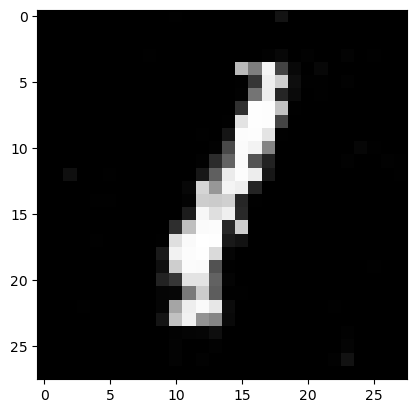

In [131]:
model_path = os.path.join(BINARIES_PATH, 'model.pth')

model_state = torch.load(model_path)

generator = Generator(28 * 28, 28 * 28).to(device)

generator.load_state_dict(generator_net.state_dict())
generator.eval()

generated_imgs_path = os.path.join(DATA_DIR_PATH, 'generated_imagery')  # this is where we'll dump images
os.makedirs(generated_imgs_path, exist_ok=True)

generated_img = generate_from_random_noise(generator)
save_and_maybe_display_image(generated_imgs_path, generated_img, should_display=True)

## PyTorch GANs :computer: :art:
This repo contains PyTorch implementation of Vanilla GAN architecture. <br/>

## Table of Contents
  * [Understanding GANs](#Understanding-GANs)
  * [Vanilla GAN](#vanilla-gan)
    
---

## Understanding GANs

GAN stands for Generative Adversarial Networks, which is a type of deep learning model that consists of two networks: a generator and a discriminator. The generator network learns to generate realistic-looking fake data (e.g. images, audio, text) from random noise, while the discriminator network learns to distinguish the fake data from the real data. The two networks are trained simultaneously in an adversarial manner, where the generator tries to fool the discriminator by generating more realistic fake data, while the discriminator tries to correctly identify the real and fake data.

The original paper introducing GANs is titled [Generative Adversarial Networks](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) and was authored by Ian Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. It was published in 2014 at the Conference on Neural Information Processing Systems (NIPS).

GANs have two components:
1. <b>Generator Network:</b> The generator network takes a random noise vector as input and generates a new image.
2. <b>Discriminator Network:</b> The discriminator network takes an image as input and outputs a scalar value indicating whether the image is real or fake.

---

## Vanilla GAN

Vanilla GAN is my implementation of the original GAN paper with certain modifications mostly in the model architecture,
like the usage of LeakyReLU and 1D batch normalization.

### Examples
    
GAN was trained on data from MNIST dataset. Here is how the digits from the dataset look like:

<div style="display: flex;">
    <img src="data/generated_imagery/generated_image0.jpg" style="width: 30%; display: inline-block;">
    <img src="data/generated_imagery/generated_image.jpg" style="width: 30%; display: inline-block;">
</div>

---

## Acknowledgements

I've used the following repositories as reference for implementing my version:
* [pytorch-GANs](https://github.com/gordicaleksa/pytorch-GANs) (PyTorch)
* [PyTorch-GAN](https://github.com/ahmadchalhoub/research_implementations) (PyTorch)